## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from skimage import io

import matplotlib.image as mpimg
import seaborn as sns
from random import sample
from itertools import chain

import sklearn.model_selection as skl

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau


Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
26008,00006832_015.png,Atelectasis|Infiltration|Mass,15,6832,20,M,PA,2500,2048,0.168,0.168,NaN,/data/images_004/images/00006832_015.png
60488,00014934_005.png,No Finding,5,14934,56,M,AP,2500,2048,0.168,0.168,NaN,/data/images_007/images/00014934_005.png
58915,00014581_002.png,No Finding,2,14581,36,F,PA,2690,2712,0.143,0.143,NaN,/data/images_007/images/00014581_002.png


In [3]:
##split Finding Labels into individual diagnosis label counts (all_labels)
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
105708,00028450_000.png,No Finding,0,28450,4,F,PA,2544,3056,0.139000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
33546,00008799_000.png,No Finding,0,8799,77,M,PA,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
93241,00023306_001.png,No Finding,1,23306,56,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [4]:
##check the Pneumonia column
all_xray_df.iloc[:,-2].sample(3)

90193    0.0
67763    0.0
10829    0.0
Name: Pneumonia, dtype: float64

In [5]:
##create a pneumonia_class column to use as strings with keras
all_xray_df['pneumonia_class']= all_xray_df.iloc[:,-2].astype(str)

In [6]:
##check the new pneumonia_class column
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
77967,00019145_005.png,No Finding,5,19145,46,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
24331,00006393_005.png,Fibrosis,5,6393,76,M,PA,2500,2048,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70470,00017369_008.png,No Finding,8,17369,52,F,PA,2992,2741,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [7]:
len(all_xray_df)

112120

In [8]:
##train test split into training and validation sets, with 0.2 reserved as the validation set
train_df, valid_df = skl.train_test_split(all_xray_df, test_size = 0.2, stratify = all_xray_df['Pneumonia'])
    

In [9]:
##proportion of the training set that is positive for pneumonia
train_df['Pneumonia'].sum()/len(train_df)

0.012765340706386016

In [10]:
##proportion of the validation set that is positive for pneumonia
valid_df['Pneumonia'].sum()/len(valid_df)

0.012754191937210132

In [11]:
##we want to adjust the training set so that there are 50% positive for pneumonia, and 50% negative for pneumonia
p_inds = train_df[train_df.Pneumonia ==1].index.tolist()
np_inds = train_df[train_df.Pneumonia ==0].index.tolist()

np_sample = sample(np_inds, len(p_inds))
train_df = train_df.loc[p_inds + np_sample]

In [12]:
train_df['Pneumonia'].sum()/len(train_df)

0.5

In [13]:
##we want the validation set to reflect something closer to the dataset, so we choose to make the negative group 
##four times as large as the positive group for pneumonia
p_inds = valid_df[valid_df.Pneumonia ==1].index.tolist()
np_inds = valid_df[valid_df.Pneumonia ==0].index.tolist()

np_sample = sample(np_inds, 4*len(p_inds))
valid_df = valid_df.loc[p_inds + np_sample]



In [14]:
##in the validation set, we have 80% negative and 20% positive
valid_df['Pneumonia'].sum()/len(valid_df)

0.2

In [15]:
len(valid_df[valid_df.Pneumonia ==1])

286

In [16]:
len(valid_df[valid_df.Pneumonia ==0])

1144

## Create your training and testing data:

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [17]:
##for image augmentation and training, must specify image size
IMG_SIZE = (224,224)

In [18]:
##image augmentation.  y_col must be a string. Batch size 100 and learning rate Adam(lr=1e-3) with 30 epochs seems good 
##to avoid overfitting and still achieve good performance
idg = ImageDataGenerator(rescale=1. / 255.0,
                            horizontal_flip = True,
                            vertical_flip = False,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 20,
                            shear_range = 0.1,
                            zoom_range= 0.1
                            )
train_gen = idg.flow_from_dataframe(dataframe=train_df,
                                 directory=None,
                                 x_col = 'path',
                                 y_col = 'pneumonia_class',
                                 class_mode = 'binary',
                                 target_size = IMG_SIZE,
                                 batch_size = 100
                                 )
val_idg = ImageDataGenerator(rescale=1. /255.0)

val_gen = idg.flow_from_dataframe(dataframe=valid_df,
                                 directory=None,
                                 x_col = 'path',
                                 y_col = 'pneumonia_class',
                                 class_mode = 'binary',
                                 target_size = IMG_SIZE,
                                 batch_size = 100
                                 )
    

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [19]:
##pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

In [20]:
print('Train', valX.min(), valX.max(), valX.mean(), valX.std())

Train 0.0 1.0 0.4864766 0.25329164


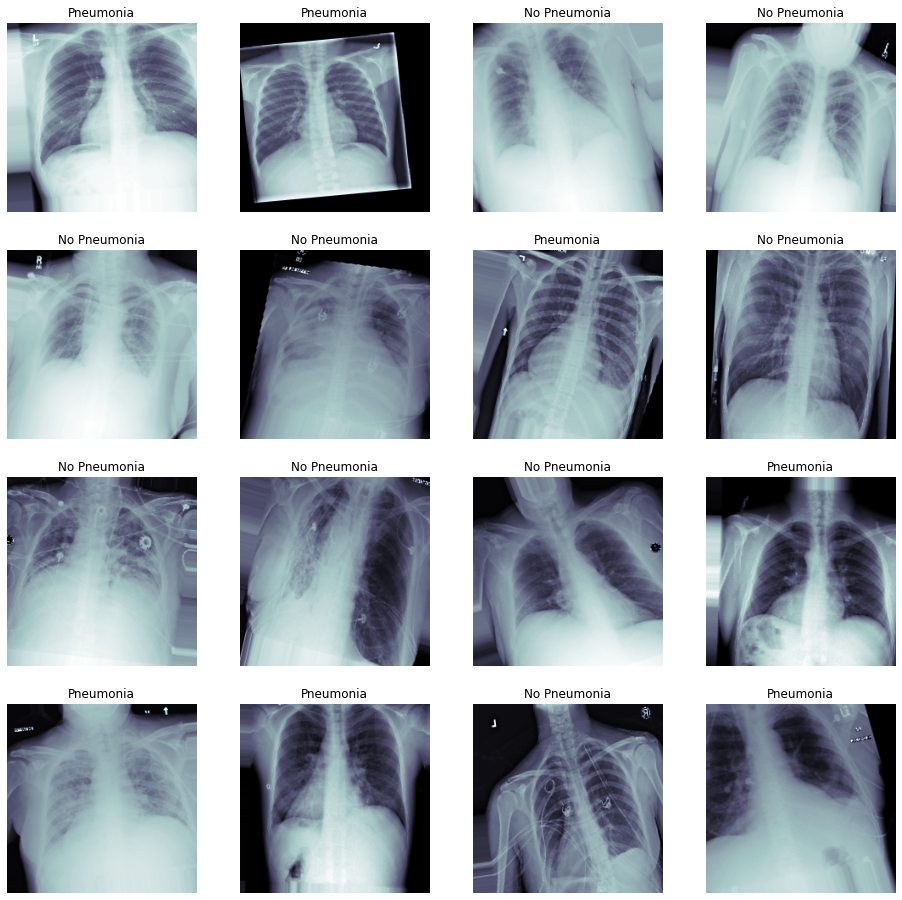

In [21]:
## look at some examples of our augmented training data in the training set. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

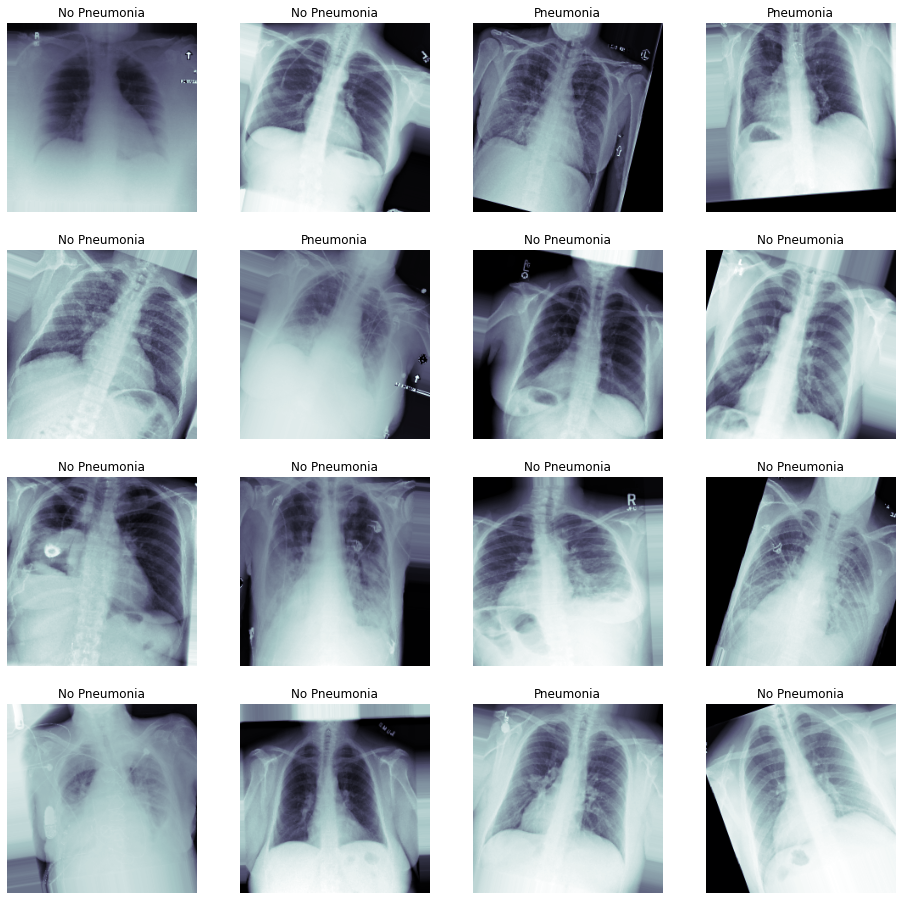

In [22]:
## look at some examples of our augmented data in the validation set. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(val_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [23]:
##we will use the built in layer VGG16 for training, plus add a few layers of our own
model = VGG16(include_top=True, weights='imagenet')
model.summary()

553467904/553467096 [==============================] - 8s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [24]:
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)

In [25]:
## we fix the model so that only the last two layers are trainable
for layer in vgg_model.layers[0:17]:
    layer.trainable = False

In [26]:
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


In [27]:
##building the actual model using Sequential().  There is the VGG16 model, and on top of that flatten,
##dropout (to reduce overfitting), and two additional dense layers.  The last layer is sigmoid so that it can 
##function as a binary classifier
my_model = Sequential()
my_model.add(vgg_model)
my_model.add(Flatten())
my_model.add(Dropout(0.5))
my_model.add(Dense(1024, activation = 'relu'))
my_model.add(Dense(1, activation = 'sigmoid'))

In [28]:
##we select a learning rate that can produce good f1 scores but won't overfit
optimizer = Adam(lr=1e-3)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [29]:
##we must compile using optimizer, loss, and metrics prior to running.
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [30]:
## helper code that adds checkpoints to your model,
## This saves the 'best' version of the model by comparing it to previous epochs of training
## The metric used for model's 'best' performance is validation loss, val_loss. 
## The 'patience' parameter is set to 7, meaning that your model will train for ten epochs without seeing
## improvement before quitting
##we have saved the weight path to my_model1.best.hdf5


weight_path="{}_my_model1.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [31]:
## train the model


history = my_model.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = 30, 
                           callbacks = callbacks_list)

Epoch 1/30
23/23 [==============================] - 96s 4s/step - loss: 1.6915 - binary_accuracy: 0.5092 - val_loss: 0.6660 - val_binary_accuracy: 0.8300

Epoch 00001: val_loss improved from inf to 0.66604, saving model to xray_class_my_model1.best.hdf5
Epoch 2/30
23/23 [==============================] - 84s 4s/step - loss: 0.6891 - binary_accuracy: 0.5437 - val_loss: 0.6929 - val_binary_accuracy: 0.5700

Epoch 00002: val_loss did not improve from 0.66604
Epoch 3/30
23/23 [==============================] - 86s 4s/step - loss: 0.6788 - binary_accuracy: 0.5664 - val_loss: 0.6322 - val_binary_accuracy: 0.7000

Epoch 00003: val_loss improved from 0.66604 to 0.63223, saving model to xray_class_my_model1.best.hdf5
Epoch 4/30
23/23 [==============================] - 60s 3s/step - loss: 0.6731 - binary_accuracy: 0.5843 - val_loss: 0.6688 - val_binary_accuracy: 0.5700

Epoch 00004: val_loss did not improve from 0.63223
Epoch 5/30
23/23 [==============================] - 60s 3s/step - loss: 0.67

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [32]:
## After training, this code below makes predictions to assess the model's overall performance
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

100/100 [==============================] - 5s 48ms/step


In [33]:
##define false positive rate, true positive rate, and thresholds, and plot an roc curve
import sklearn.metrics as sklm
fpr, tpr, thresholds = sklm.roc_curve(valY, pred_Y, pos_label=None)



In [34]:
fpr

array([0.        , 0.        , 0.01204819, 0.01204819, 0.02409639,
       0.02409639, 0.03614458, 0.03614458, 0.04819277, 0.04819277,
       0.07228916, 0.07228916, 0.14457831, 0.14457831, 0.15662651,
       0.15662651, 0.21686747, 0.21686747, 0.22891566, 0.22891566,
       0.24096386, 0.24096386, 0.3373494 , 0.3373494 , 0.40963855,
       0.40963855, 0.51807229, 0.51807229, 0.74698795, 0.74698795,
       1.        ])

In [35]:
tpr

array([0.        , 0.05882353, 0.05882353, 0.11764706, 0.11764706,
       0.17647059, 0.17647059, 0.23529412, 0.23529412, 0.29411765,
       0.29411765, 0.41176471, 0.41176471, 0.47058824, 0.47058824,
       0.58823529, 0.58823529, 0.64705882, 0.64705882, 0.70588235,
       0.70588235, 0.76470588, 0.76470588, 0.82352941, 0.82352941,
       0.88235294, 0.88235294, 0.94117647, 0.94117647, 1.        ,
       1.        ])

In [36]:
thresholds

array([1.6790991 , 0.679099  , 0.65204585, 0.6116506 , 0.6115754 ,
       0.61126125, 0.60626173, 0.602041  , 0.5952087 , 0.59441006,
       0.57911235, 0.5639786 , 0.5436125 , 0.54295874, 0.5426226 ,
       0.5326079 , 0.50557506, 0.5054652 , 0.49609303, 0.49507558,
       0.4932298 , 0.48653743, 0.4581731 , 0.45714018, 0.4381806 ,
       0.4373419 , 0.39792758, 0.39473262, 0.35398763, 0.34694976,
       0.17159945], dtype=float32)

In [37]:
##determine f1_scores associated with each threshold

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix
from sklearn.preprocessing import binarize
precision, recall, thresholds = precision_recall_curve(valY.astype(int), pred_Y)
f1_scores = []
for i in thresholds:
    f1 = f1_score(valY.astype(int), binarize(pred_Y,i))
    f1_scores.append(f1)    


In [38]:
f1 = f1_score(valY.astype(int), binarize(pred_Y,.4))
f1

0.40540540540540543

In [48]:
f1 = f1_score(valY.astype(int), binarize(pred_Y,.48))
f1

0.5

In [49]:
f1 = f1_score(valY.astype(int), binarize(pred_Y,.49))
f1

0.48979591836734687

In [50]:
f1 = f1_score(valY.astype(int), binarize(pred_Y,.47))
f1

0.4727272727272727

In [42]:
f1 = f1_score(valY.astype(int), binarize(pred_Y,.3))
f1

0.3090909090909091

In [43]:
f1 = f1_score(valY.astype(int), binarize(pred_Y,.39))
f1

0.4155844155844156

(<matplotlib.legend.Legend at 0x7fdeef8d2dd0>,)

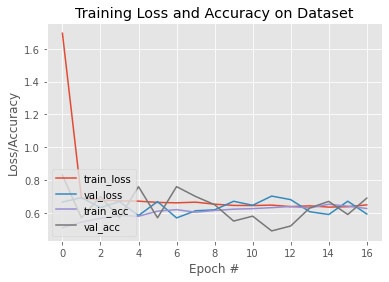

In [44]:
##plot epoch history

N = len(history.history["loss"]) 

plt.style.use("ggplot")

plt.figure()

plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")

plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")

plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")

plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy on Dataset")

plt.xlabel("Epoch #")

plt.ylabel("Loss/Accuracy")

plt.legend(loc="lower left"),

Text(0, 0.5, 'True Positive Rate')

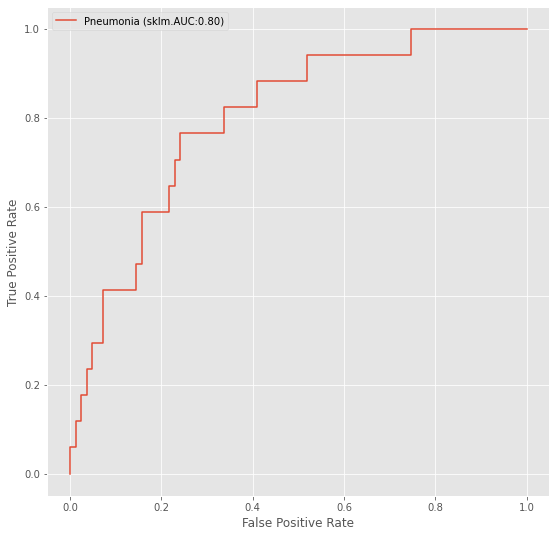

In [45]:
##roc curve
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
fpr, tpr, thresholds = sklm.roc_curve(valY, pred_Y)
c_ax.plot(fpr, tpr, label = '%s (sklm.AUC:%0.2f)'  % ('Pneumonia', sklm.auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

Text(0, 0.5, 'Precision')

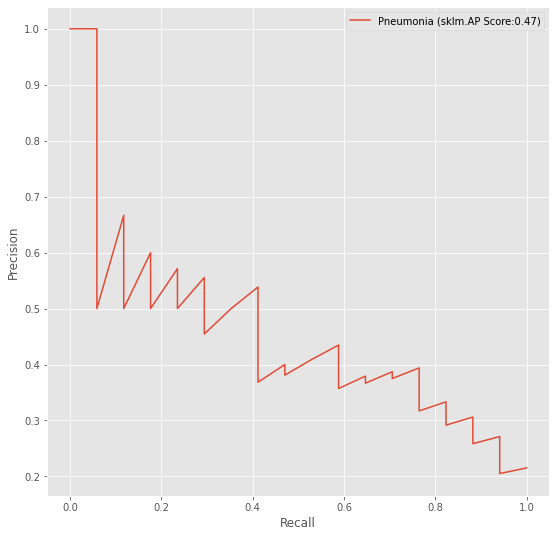

In [46]:
## precision recall curve
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
precision, recall, thresholds = sklm.precision_recall_curve(valY, pred_Y)
c_ax.plot(recall, precision, label = '%s (sklm.AP Score:%0.2f)'  % ('Pneumonia', sklm.average_precision_score(valY, pred_Y)))
c_ax.legend()
c_ax.set_xlabel('Recall')
c_ax.set_ylabel('Precision')

Text(0, 0.5, 'F1 Score')

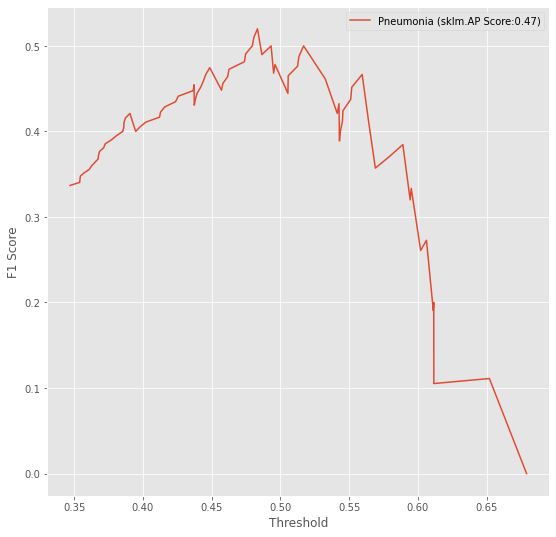

In [47]:
## f1 score threshold curve
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
precision, recall, thresholds = sklm.precision_recall_curve(valY, pred_Y)
c_ax.plot(thresholds, f1_scores, label = '%s (sklm.AP Score:%0.2f)'  % ('Pneumonia', sklm.average_precision_score(valY, pred_Y)))
c_ax.legend()
c_ax.set_xlabel('Threshold')
c_ax.set_ylabel('F1 Score')

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

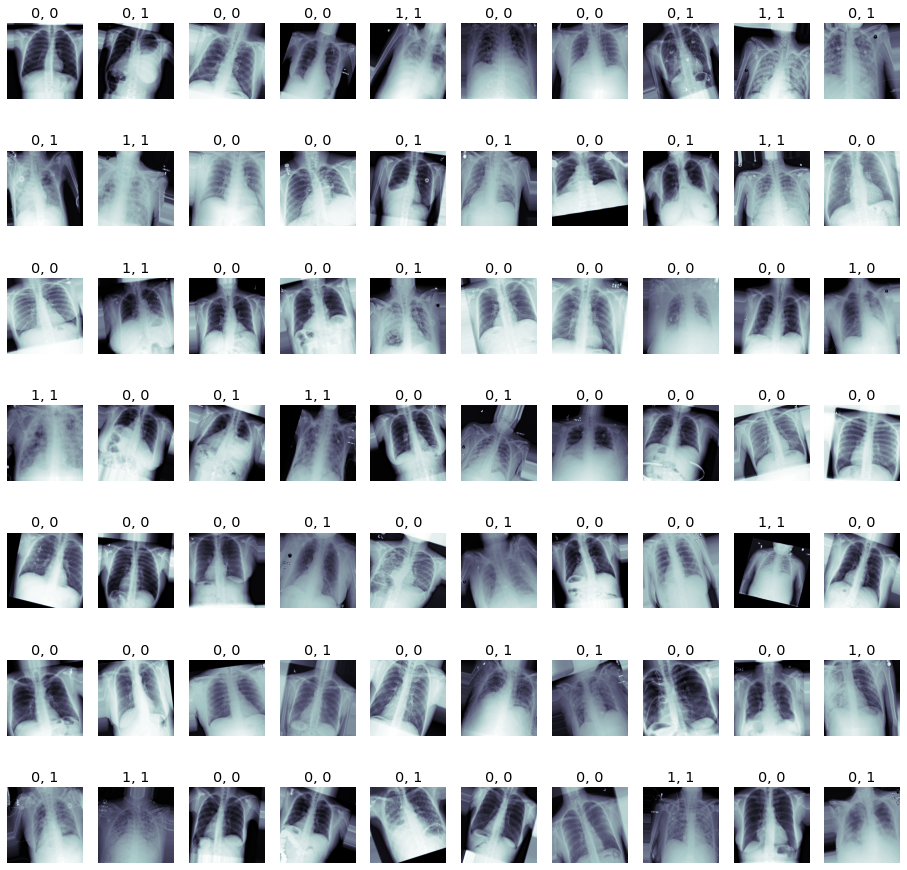

In [51]:
## examples of true vs. predicted with our best model: 


fig, m_axs = plt.subplots(7, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:70], valY[0:70], m_axs.flatten()):
     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
     if c_y == 1: 
         if pred_Y[i] > 0.48:
             c_ax.set_title('1, 1')
         else:
             c_ax.set_title('1, 0')
     else:
         if pred_Y[i] > 0.48: 
             c_ax.set_title('0, 1')
         else:
             c_ax.set_title('0, 0')
     c_ax.axis('off')
     i=i+1

In [52]:
## save model architecture to a .json:

model1_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model1_json)